### SEPC Sparse Matrix Operations

Separate Conda ENV as many dependecies

In [1]:
import sys, slepc4py
slepc4py.init(sys.argv)


In [29]:
from petsc4py import PETSc
from slepc4py import SLEPc
import numpy as np
import scipy 
from scipy.sparse import dia_matrix, csr_matrix
import matplotlib.pyplot as plt

### Specifies command line interface 

In [123]:
opts = PETSc.Options()
n = opts.getInt('n', 10)

### Constructs 2nd Order Difference Matrix 

In [124]:
A = PETSc.Mat().create()
A.setSizes([n-2, n])
A.setFromOptions()
A.setUp()

rstart, rend = A.getOwnershipRange()


# first row
if rstart == 0:
    A[0, :3] = [1, -2 ,1]
    rstart += 1
# last row
if rend == n+1:
    A[n, -3:] = [-2, 1]
    rend -= 1
# other rows
for i in range(rstart+1, rend+1):
    A[i-1, i-1:i+2] = [1, -2, 1]

A.assemble()

In [125]:
#A.view()

In [126]:
A.size


(8, 10)

In [127]:
E = SLEPc.SVD(); E.create()

In [128]:
E.setOperators(A)
E.setDimensions(8) # set dimensions as size of system
E.setProblemType(SLEPc.SVD.ProblemType.STANDARD)
E.setType("lanczos")
E.setFromOptions()

In [129]:
E.solve()

In [130]:
Print = PETSc.Sys.Print

Print()
Print("******************************")
Print("*** SLEPc Solution Results ***")
Print("******************************")
Print()

its = E.getIterationNumber()
Print("Number of iterations of the method: %d" % its)

eps_type = E.getType()
Print("Solution method: %s" % eps_type)

nev, ncv, mpd = E.getDimensions()
Print(f"Number of requested eigenvalues: {nev,ncv,mpd}")

tol, maxit = E.getTolerances()
Print("Stopping condition: tol=%.4g, maxit=%d" % (tol, maxit))


******************************
*** SLEPc Solution Results ***
******************************

Number of iterations of the method: 1
Solution method: lanczos
Number of requested eigenvalues: (8, 8, 8)
Stopping condition: tol=1e-08, maxit=100


In [131]:
nconv = E.getConverged()
Print("Number of converged eigenpairs %d" % nconv)

Number of converged eigenpairs 8


In [132]:
vals=np.array([E.getValue(i) for i in range (0,8)])


In [83]:
n=400
u=[]
v=[]

 
for i in range(0,n-2):
    # difficult memory allocation
    u_ = PETSc.Vec().createSeq(n-2) 
    v_ = PETSc.Vec().createSeq(n) 

    E.getVectors(i,u_,v_) 
    u.append(u_.getArray())
    v.append(v_.getArray())
 
    
u=np.array(u).T
v=np.array(v).T

array([3.88683786, 3.56062717, 3.05953237, 2.44181126, 1.77844301,
       1.14409788, 0.60736609, 0.22479323])

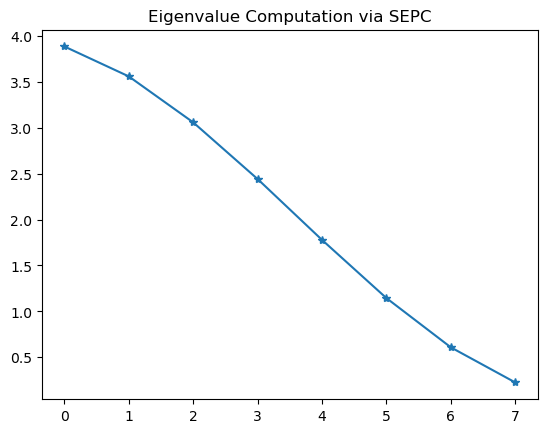

In [138]:
plt.title("Eigenvalue Computation via SEPC")
plt.plot(vals,marker='*')
vals

### Computing the inverse

In [90]:
from petsc4py import PETSc
from slepc4py import SLEPc
import numpy as np

def sparse_inversion (A,algorithm='lanczos'):
    '''
     Computes the inverse of sparse matrices via SVD through SLEPc and PETSc
     
     Default Algorithm is Lanczos Algorithm
    
    '''
    
    

    
    r,c=A.shape
    
    
    A=csr_matrix(A)

    p1=A.indptr
    p2=A.indices
    p3=A.data
    A_p = PETSc.Mat().createAIJ(size=A.shape,csr=(p1,p2,p3))

    
    E.setOperators(A_p)
    E.setDimensions(r) 
    E.setProblemType(SLEPc.SVD.ProblemType.STANDARD) # standard svd decomposition
    E.setType(algorithm)
    E.setFromOptions()
    
    E.solve()
    
    eigs=np.array([E.getValue(i) for i in range (0,r)])
    
    u=[]
    v=[]

 
    for i in range(0,r):
        
        # memory allocation 
        u_ = PETSc.Vec().createSeq(r) 
        v_ = PETSc.Vec().createSeq(c) 

        E.getVectors(i,u_,v_) 
        u.append(u_.getArray())
        v.append(v_.getArray())


    u=np.array(u).T
    v=np.array(v).T
    
    s=np.diagflat((1/eigs)**2)
    l=np.matmul(np.matmul(u,s),u.T)
    
    '''
        Safeguard against unstable inverses 
    '''
    
    return l
    

In [115]:
coeff=[1,-2,1]
n=400

t=dia_matrix((np.vstack([i*np.ones(n) for i in coeff]),range(0,len(coeff))),shape=(n-2,n)).toarray()

t_orig=np.matmul(t,t.T)


inv=sparse_inversion(t)

In [116]:
np.round(np.matmul(inv,t_orig))

array([[ 1.,  0., -0., ...,  0., -0.,  0.],
       [ 0.,  1., -0., ...,  0., -0.,  0.],
       [ 0.,  0.,  1., ...,  0., -0.,  0.],
       ...,
       [-0.,  0., -0., ...,  1.,  0., -0.],
       [-0.,  0., -0., ...,  0.,  1., -0.],
       [-0.,  0., -0., ...,  0.,  0.,  1.]])